__Import libraries__

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance
from math import ceil


## Helper functions

In [2]:
def create_date_features(df):
    
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    #df['dayofyear'] = df['Date'].dt.dayofyear
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    

    def week_of_month(dt):
        """ Returns the week of the month for the specified date.
        """

        first_day = dt.replace(day=1)

        dom = dt.day
        adjusted_dom = dom + first_day.weekday()

        return int(ceil(adjusted_dom/7.0))
    
    df['weekofmonth'] = df['Date'].apply(week_of_month)
    
    return df

In [3]:
def till_func(x,holiday_dates):
    return min([diff for diff in (x-holiday_dates).days if diff>=0],default=-1)//7

def since_func(x,holiday_dates):
    return abs(max([diff for diff in (x-holiday_dates).days if diff<=0],default=-1)//7)


def add_since_till_holiday_feature(df,feature_name,holiday_dates,till_since_func,date_column='Date'):
    data = df.copy()
    data = data.assign(new_col=data['Date'].apply(till_since_func,args=(holiday_dates,)))
    data.rename(columns = {'new_col':feature_name},inplace=True)
    return data

In [4]:
def one_hot_encoding(train,test,cat_features):
    ohe = OneHotEncoder()
    
    ohe_train = ohe.fit_transform(train[cat_features]).toarray()
    ohe_train = pd.DataFrame(ohe_train,columns=ohe.get_feature_names())
    train.drop(cat_features,axis=1,inplace=True)
    train.reset_index(drop=True,inplace=True)
    train = pd.concat([train,ohe_train],axis=1)
    
    ohe_test = ohe.transform(test[cat_features]).toarray()
    ohe_test = pd.DataFrame(ohe_test,columns=ohe.get_feature_names())
    test.drop(cat_features,axis=1,inplace=True)
    test.reset_index(drop=True,inplace=True)
    test = pd.concat([test,ohe_test],axis=1)
    
    return (train,test)

In [5]:
def imputing(train,test,num_features):
    imputer = SimpleImputer(strategy='constant',fill_value=0)

    imp_train = pd.DataFrame(imputer.fit_transform(train[num_features]),columns=num_features)
    train[num_features] = imp_train
    
    imp_test = pd.DataFrame(imputer.transform(test[num_features]),columns=num_features)
    test[num_features] = imp_test
    
    return train,test

In [6]:
def get_store(data,store=None,dept=None):
    
    if ((store == None) & (dept == None)):
        print('Enter something atleast')
    
    if (dept == None):
        return data[(data.Store==store)]
    
    if (store == None):
        return data[(data.Dept==dept)]
    
    else:
        return data[(data.Store==store)&(data.Dept==dept)]

In [7]:
def custom_loss_scorer(estimator,X,y):
    weight_array = np.where(X.IsHoliday==True,5,1)
    preds = estimator.predict(X)
    error = np.mean(weight_array*np.abs(y-preds))
    
    return -(error)

In [8]:
def create_lag_features(df,lags):
    lags = range(39, lags+1)  # Just two lags for demonstration.

    df = df.assign(**{'Weekly_sales(t-{})'.format(t): df.groupby(['Store','Dept']).Weekly_sales.shift(t) for t in lags})

    return df

In [9]:
def create_window_features(df,lags):
    lags = range(39, lags+1)

    df = df.assign(**{'rolling_mean_{}'.format(t): df.groupby(['Store','Dept'])['Weekly_sales'].rolling(t,min_periods=1).mean().reset_index(drop=True) for t in lags})

    return df

In [10]:
def wmse(pred,ws,isholiday):
    weights = np.where(isholiday,5,1)
    return np.mean(weights*np.abs(pred-ws))

__Import Data__

In [11]:
features = pd.read_csv('walmart-recruiting-store-sales-forecasting/features.csv',parse_dates=[1])
stores = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('walmart-recruiting-store-sales-forecasting/test.csv',parse_dates=[2])
train = pd.read_csv('walmart-recruiting-store-sales-forecasting/train.csv',parse_dates=[2])

__Merge data into 1 DataFrame__

In [12]:
train_data = pd.merge(left=pd.merge(left=train,right=stores,how='left'),right=features,how='left',on=['Store','Date','IsHoliday'])
test_data = pd.merge(left = pd.merge(left=test,right=stores,how='left'),right=features,how='left',on = ['Store','Date','IsHoliday'])

__Add Features__

In [13]:
train_data['CPI_cat'] = np.where(train_data.CPI<160,'LowCPI','HighCPI')
test_data['CPI_cat'] = np.where(test_data.CPI<160,'LowCPI','HighCPI')

train_data['Size_cat'] = np.where(train_data.Size<75000,'Small_Size',np.where(train_data.Size<175000,'Mid_Size','High_Size'))
test_data['Size_cat'] = np.where(test_data.Size<75000,'Small_Size',np.where(test_data.Size<175000,'Mid_Size','High_Size'))

In [14]:
sb_dates = pd.to_datetime(['2010-02-12','2011-02-11','2012-02-10','2013-02-08'])
labor_dates = pd.to_datetime(['2010-09-10','2011-09-09','2012-09-07','2013-09-06'])
thanksgiving_dates = pd.to_datetime(['2010-11-26','2011-11-25','2012-11-23','2013-11-29'])
christmas_dates = pd.to_datetime(['2010-12-31','2011-12-30','2012-12-28','2013-12-27'])



train_data['Which_Holiday'] = 'NoHoliday'
train_data.loc[(np.isin(train_data[['Date']].values, sb_dates.values).reshape(-1)),'Which_Holiday'] = 'Super_Bowl'
train_data.loc[(np.isin(train_data[['Date']].values, labor_dates.values).reshape(-1)),'Which_Holiday'] = 'Labor_Day'
train_data.loc[(np.isin(train_data[['Date']].values, thanksgiving_dates.values).reshape(-1)),'Which_Holiday'] = 'Thanksgiving'
train_data.loc[(np.isin(train_data[['Date']].values, christmas_dates.values).reshape(-1)),'Which_Holiday'] = 'Christmas'

test_data['Which_Holiday'] = 'NoHoliday'
test_data.loc[(np.isin(test_data[['Date']].values, sb_dates.values).reshape(-1)),'Which_Holiday'] = 'Super_Bowl'
test_data.loc[(np.isin(test_data[['Date']].values, labor_dates.values).reshape(-1)),'Which_Holiday'] = 'Labor_Day'
test_data.loc[(np.isin(test_data[['Date']].values, thanksgiving_dates.values).reshape(-1)),'Which_Holiday'] = 'Thanksgiving'
test_data.loc[(np.isin(test_data[['Date']].values, christmas_dates.values).reshape(-1)),'Which_Holiday'] = 'Christmas'


__Create data for log scaled target__

In [15]:
train_log = train_data[train_data.Weekly_Sales>0]
train_log.loc[:,'Weekly_Sales_log'] = np.log(train_log.Weekly_Sales)

C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


__Seperating targets__

In [16]:
weekly_sales = train_data.Weekly_Sales
weekly_sales_log = train_log.Weekly_Sales_log
weekly_sales_log_org = train_log.Weekly_Sales

train_data.drop('Weekly_Sales',axis=1,inplace=True)
train_log.drop(['Weekly_Sales_log','Weekly_Sales'],axis=1,inplace=True)


C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [17]:
sb_dates = pd.to_datetime(['2010-02-12','2011-02-11','2012-02-10','2013-02-08'])
labor_dates = pd.to_datetime(['2010-09-10','2011-09-09','2012-09-07','2013-09-06'])
thanksgiving_dates = pd.to_datetime(['2010-11-26','2011-11-25','2012-11-23','2013-11-29'])
christmas_dates = pd.to_datetime(['2010-12-31','2011-12-30','2012-12-28','2013-12-27'])

holiday_dates = sb_dates.append(labor_dates).append(thanksgiving_dates).append(christmas_dates)

In [18]:
all_holiday_dates = [holiday_dates,sb_dates,labor_dates,thanksgiving_dates,christmas_dates]
till_feature_names = ['WeeksTillNextHoliday','WeeksTillNextSuperBowl','WeeksTillLaborDay','WeeksTillNextThanksgiving','WeeksTillNextChristmas']
since_feature_names = ['WeeksSinceLastHoliday','WeeksSinceLastSuperBowl','WeeksSinceLastLaborDay','WeeksSinceLastThanksgiving','WeeksSinceLastChristmas']                     

The following cells have been commented out because it takes a long time for the code to run. So i ran i once and saved the tables. To use it for the first time, this will need to be uncommented

In [19]:
##for till_feature,since_feature,dates in (zip(till_feature_names,since_feature_names,all_holiday_dates)):
    
##    train_data[till_feature] = train_data.Date.apply(till_func,args = (dates,))
##    test_data[till_feature] = test_data.Date.apply(till_func,args = (dates,))
##    print("Completed till feature " + till_feature)
    
##    train_data[since_feature] = train_data.Date.apply(since_func,args = (dates,))
##    test_data[since_feature] = test_data.Date.apply(since_func,args = (dates,))
##    print("Completed since feature " + since_feature)

In [20]:
#train_data.to_csv('train_data_holiday_features.csv',index=False)
#test_data.to_csv('test_data_holiday_features.csv',index=False)

In [21]:
train_data = pd.read_csv('train_data_holiday_features.csv',parse_dates=[2])
test_data = pd.read_csv('test_data_holiday_features.csv',parse_dates=[2])


__Preprocessing__

In [22]:
num_features = train_data.columns[np.isin(train_data.dtypes,['int64','float64'])]
cat_features = train_data.columns[train_data.dtypes=='object']

**OneHotEncoding and Missing value imputation**

In [23]:
train_data,test_data = one_hot_encoding(train_data,test_data,cat_features)

In [24]:
train_data,test_data = imputing(train_data,test_data,num_features)

**Creating date features**

In [25]:
X = create_date_features(train_data)
test_data = create_date_features(test_data)

In [26]:
X_sales = X.copy()
X_sales['Weekly_sales'] = weekly_sales
#corr_mat = X_sales.corr()

**Department contribution feature**

This feature is the ratio of each Department's average monthly sales with the Store's average monthly sales. The rational here is that the ratio would be a measure of how much the department's sales contribute to the sales of the store for each month.

In [27]:
Store_monthly_average = X_sales.groupby(['Store','month']).Weekly_sales.mean().reset_index()
Store_dept_monthly_average = X_sales.groupby(['Store','Dept','month']).Weekly_sales.mean().reset_index()
monthly_dept_contrib = pd.merge(left=Store_dept_monthly_average,right=Store_monthly_average,on=['Store','month'],how='inner')
monthly_dept_contrib.columns = ['Store', 'Dept', 'month', 'Store_Dept_month_avg', 'Store_month_avg']
monthly_dept_contrib['dept_contrib'] = monthly_dept_contrib.Store_Dept_month_avg/monthly_dept_contrib.Store_month_avg
X_sales = pd.merge(left=X_sales,right=monthly_dept_contrib,on=['Store','Dept','month'],how='left')
test_d = pd.merge(left=test_data,right=monthly_dept_contrib,on=['Store','Dept','month'],how='left')

### lag and rolling mean features

In [28]:
X_sales['set']='Train'
test_d['set']='Test'
test_d['Weekly_sales']=0

In [29]:
all_data=pd.concat([X_sales,test_d],ignore_index=True)

C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [30]:
all_data_lag=create_lag_features(all_data,52)

In [31]:
X_lag_sales = create_lag_features(X_sales.copy(),52)

In [32]:
X_train = all_data_lag[all_data_lag.set=='Train']
X_test = all_data_lag[all_data_lag.set=='Test']

y_train = X_train.Weekly_sales
X_train.drop(['Weekly_sales','Date','set'],axis=1,inplace=True)
X_test.drop(['Weekly_sales','Date','set'],axis=1,inplace=True)

C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Model Training

In [33]:
model = XGBRegressor(max_depth=7,
                            col_sample_bytree=0.9,
                            min_child_weight=1,
                            n_estimators=500,
                            subsample=0.9,
                            learning_rate=0.1,
                            gamma=0,
                            n_jobs=-1, seed=28)

grid_search = GridSearchCV(estimator=model,
                           param_grid={},
                           scoring=custom_loss_scorer,
                           cv=TimeSeriesSplit(n_splits=4),
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train,y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
print(best_parameters)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 42.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 42.1min finished
C:\Users\shahb\AnacondaPython\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\shahb\AnacondaPython\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[21:17:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: -2249.225
Best parameters set:
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 500, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 28, 'silent': None, 'subsample': 0.9, 'verbosity': 1, 'col_sample_bytree': 0.9}


In [34]:
pd.DataFrame(grid_search.cv_results_)

C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shahb\AnacondaPython\lib\site-p

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,1830.423742,535.227735,7.197275,4.715491,{},-2768.989998,-2499.302214,-1923.838877,-1804.769011,-2249.225025,398.782999,1,-998.387475,-1289.824671,-1437.472075,-1448.030011,-1293.428558,181.460996


In [35]:
train_preds = grid_search.best_estimator_.predict(X_train)
train_copy = train_data.copy()
train_copy['preds'] = (train_preds)
train_copy['Date'] = train['Date']
train_copy['Weekly_Sales'] = weekly_sales


C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


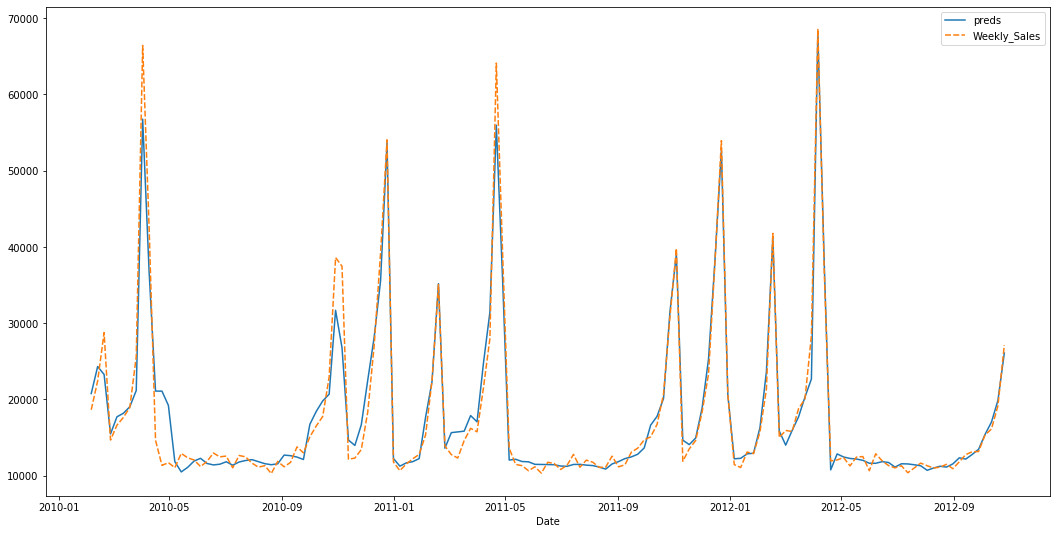

In [36]:
t_1_1 = train_copy[(train_copy.Store==45) & (train_copy.Dept==1)]
t_1_1.set_index('Date',inplace=True)
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=t_1_1[['preds','Weekly_Sales']])

In [37]:
all_test_preds = grid_search.best_estimator_.predict(X_test)
test_output = test_data.copy()
test_output['preds'] = all_test_preds
test_output['id'] = test_output['Store'].astype(int).astype(str) + '_' +  test_output['Dept'].astype(int).astype(str) + '_' +  test['Date'].astype(str)
test_output = test_output[['id', 'preds']]
test_output = test_output.rename(columns={'id': 'Id', 'preds': 'Weekly_Sales'})

test_output.to_csv('big_xgb_test_preds.csv', index=False)

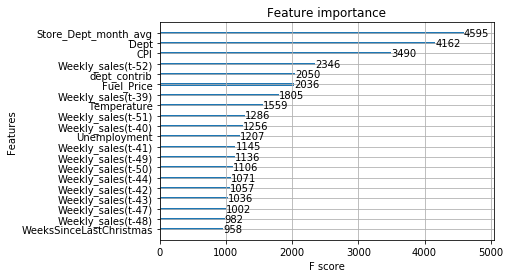

In [38]:
plot_importance(grid_search.best_estimator_,max_num_features=20);

In [39]:
train_copy[['Store','Dept','Date','preds']].to_csv('big_xgb_train_preds.csv',index=False)

In [40]:
wmse(train_copy.preds,train_copy.Weekly_Sales,train_copy.IsHoliday)

1395.7430419208652